In [19]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.signal import butter, lfilter
from scipy.integrate import cumulative_trapezoid

import os
from HelperFunctions import *

import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
base_path = os.getcwd()
data_path = os.path.join(base_path, 'Data')
data_files = os.listdir(data_path)

In [21]:
df = pd.read_csv(os.path.join(data_path, data_files[0]))


In [22]:
# Checking how many zeros we have in the lidar distance
num_zeros = (df['_current_lidar_distance_distance'] == 0).sum()
print("Precentage of zeros in lidar distance: {:.2f}%".format((num_zeros / len(df)) * 100))

Precentage of zeros in lidar distance: 15.33%


In [167]:
# Removing all the rows where the lidar distance is zero. putting it on a new df
df_non_zero = df[df['_current_lidar_distance_distance'] != 0]

# Removing last 25 rows -- The battery was dead.
# Reseting the index of the dataframe
df_non_zero = df_non_zero[df_non_zero['time_sec'] < 350]
df_non_zero.reset_index(drop=True, inplace=True)


In [168]:
x_cols = ['_current_lidar_distance_distance','_drone_header_current']
u_cols = ['_rc_channel_data_data[2]'] # This is the Thrust PWM value
dt = df_non_zero['time_sec']

x = df_non_zero[x_cols].copy()
u = df_non_zero[u_cols].copy()

# Renaming the columns for clarity
x.columns = ['distance', 'current']
u.columns = ['thrust_pwm']  # This is the Thrust PWM value

x['time_sec'] = dt.values
u['time_sec'] = dt.values

In [169]:
# Reset index to ensure proper alignment
x = x.reset_index(drop=True)
dt = dt.reset_index(drop=True)

# Calculate derivative using central difference
def calculate_derivative(signal, time):
    """Calculate derivative using central difference for interior points"""
    deriv = np.zeros_like(signal)
    
    # Central difference for interior points
    deriv[1:-1] = (signal.iloc[2:].values - signal.iloc[:-2].values) / (time.iloc[2:].values - time.iloc[:-2].values)
    
    # Forward difference for first point
    deriv[0] = (signal.iloc[1] - signal.iloc[0]) / (time.iloc[1] - time.iloc[0])
    
    # Backward difference for last point
    deriv[-1] = (signal.iloc[-1] - signal.iloc[-2]) / (time.iloc[-1] - time.iloc[-2])
    
    return deriv

# Calculate derivative
x['distance_dot'] = calculate_derivative(x['distance'], dt)

# Calculate integral using trapezoidal rule (handles variable dt correctly)
x['distance_int'] = np.concatenate([[0], cumulative_trapezoid(x['distance'], dt)])

x_cols_order = ['time_sec', 'distance', 'distance_dot', 'distance_int', 'current']
x = x[x_cols_order]

u_cols_order = ['time_sec', 'thrust_pwm']
u = u[u_cols_order]

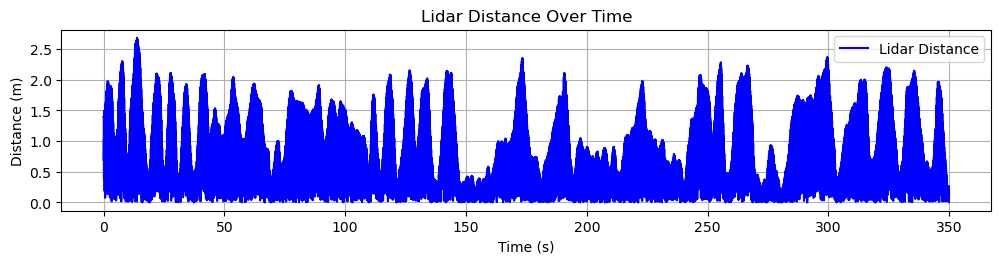

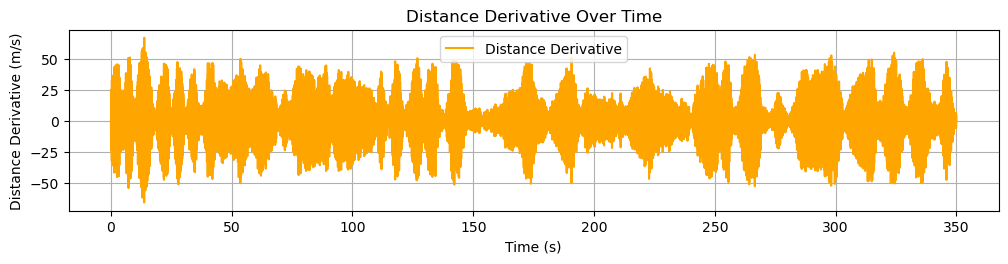

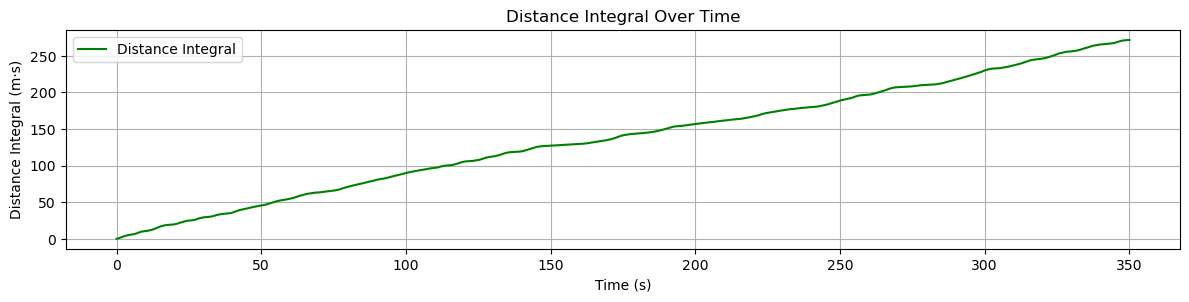

In [170]:
#plotting the lidar data vs time. Doint it as 3 subplots
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(dt, x['distance'], label='Lidar Distance', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.title('Lidar Distance Over Time')
plt.legend()
plt.grid()
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 2)
plt.plot(dt, x['distance_dot'], label='Distance Derivative', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Distance Derivative (m/s)')
plt.title('Distance Derivative Over Time')
plt.legend()
plt.grid()
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 3)
plt.plot(dt, x['distance_int'], label='Distance Integral', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Distance Integral (m·s)')
plt.title('Distance Integral Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


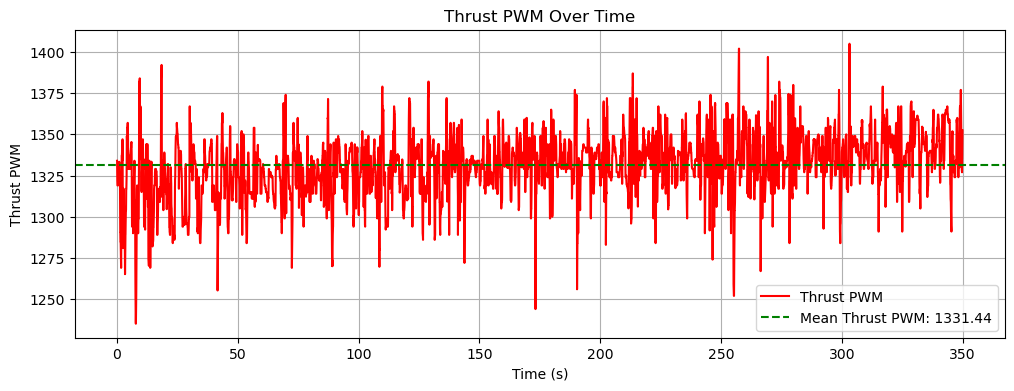

In [171]:
# Plotting the thrust pwm vs time. Adding the mean value to the plot
PWM_mean = u['thrust_pwm'].mean()

plt.figure(figsize=(12, 4))
plt.plot(dt, u['thrust_pwm'], label='Thrust PWM', color='red')
plt.axhline(PWM_mean, color='green', linestyle='--', label='Mean Thrust PWM: {:.2f}'.format(PWM_mean))
plt.xlabel('Time (s)')
plt.ylabel('Thrust PWM')
plt.title('Thrust PWM Over Time')
plt.legend()
plt.grid()
plt.show()


In [491]:
# Filtering all the data with the same HPF configuration
# Here it will be a basic 1st order High Pass Filter (HPF)
x_filtered = x.copy()
cutoff = 0.01  # Cutoff frequency in Hz
x_filtered['distance'], _ = adaptive_hpf(x_filtered, 'distance', 'time_sec', cutoff)
x_filtered['current'], _ = adaptive_hpf(x_filtered, 'current', 'time_sec', cutoff)
x_filtered['distance_dot'], _ = adaptive_hpf(x_filtered, 'distance_dot', 'time_sec', cutoff)
x_filtered['distance_int'], _ = adaptive_hpf(x_filtered, 'distance_int', 'time_sec', cutoff)

u_filtered = u.copy()
u_filtered['thrust_pwm'], _ = adaptive_hpf(u_filtered, 'thrust_pwm', 'time_sec', cutoff)

u_FF = u.copy()
# Filtering the thrust with a LPF
u_FF['thrust_pwm'], _ = adaptive_LPF(u_FF, 'thrust_pwm', 'time_sec', cutoff)
FF_mean = u_FF['thrust_pwm'].mean()

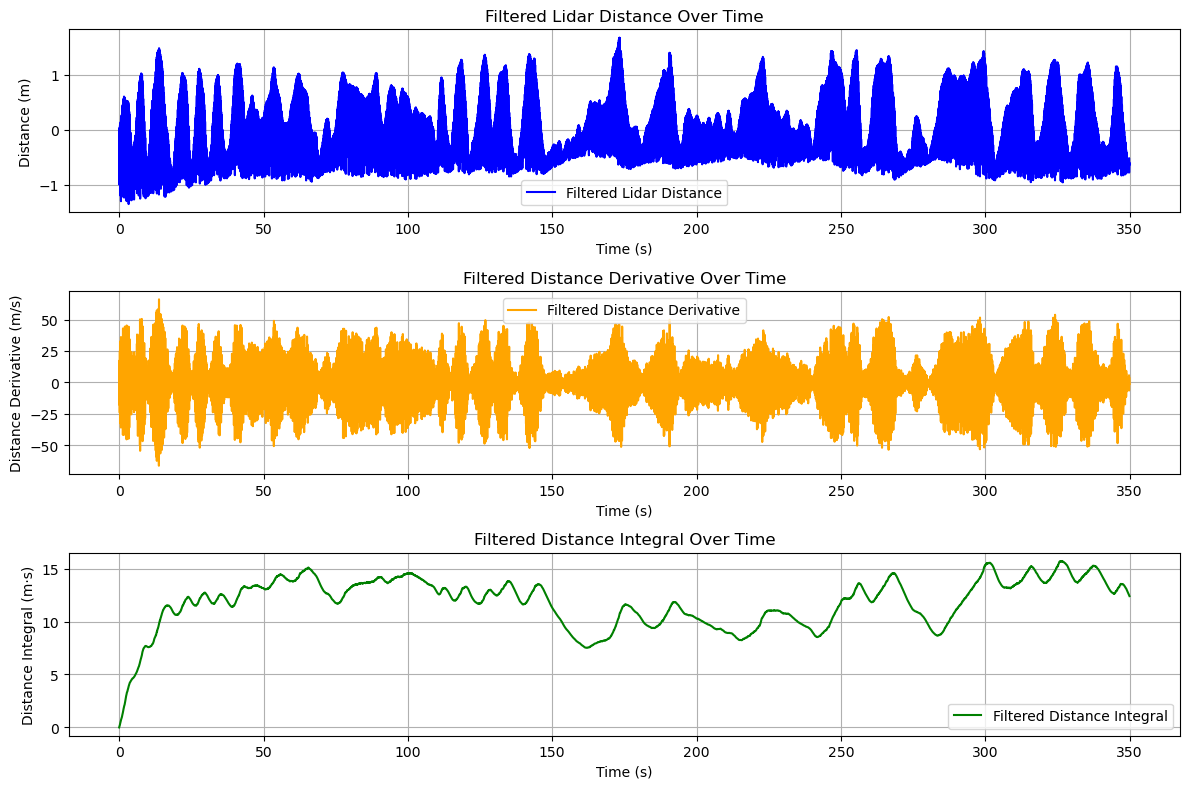

In [492]:
# Plotting the filtered data, same as before
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(dt, x_filtered['distance'], label='Filtered Lidar Distance', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.title('Filtered Lidar Distance Over Time')
plt.legend()
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(dt, x_filtered['distance_dot'], label='Filtered Distance Derivative', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Distance Derivative (m/s)')
plt.title('Filtered Distance Derivative Over Time')
plt.legend()
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(dt, x_filtered['distance_int'], label='Filtered Distance Integral', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Distance Integral (m·s)')
plt.title('Filtered Distance Integral Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

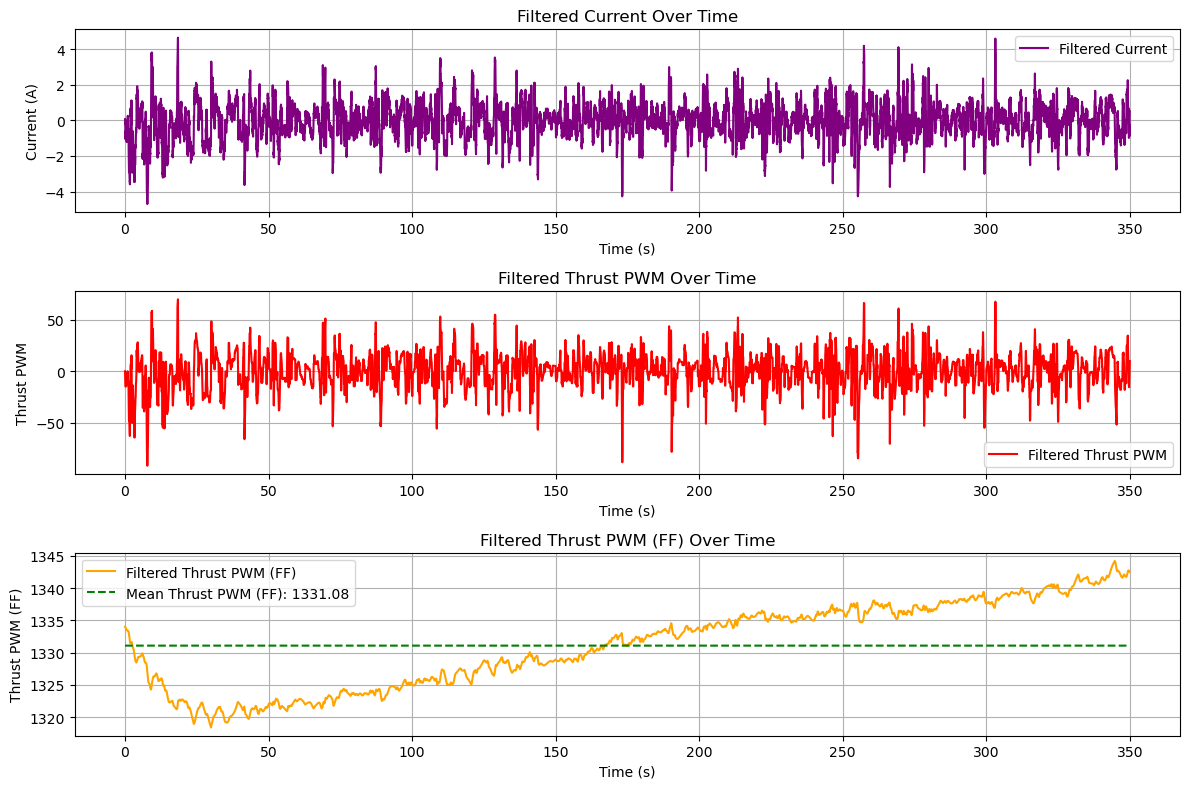

In [493]:
# Plotting the PWM after filtering
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(dt,x_filtered['current'], label='Filtered Current', color='purple')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Filtered Current Over Time')
plt.legend()
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(dt, u_filtered['thrust_pwm'], label='Filtered Thrust PWM', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Thrust PWM')
plt.title('Filtered Thrust PWM Over Time')
plt.legend()
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(dt, u_FF['thrust_pwm'], label='Filtered Thrust PWM (FF)', color='orange')
plt.plot(dt, [FF_mean]*len(dt), label='Mean Thrust PWM (FF): {:.2f}'.format(FF_mean), linestyle='--', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Thrust PWM (FF)')
plt.title('Filtered Thrust PWM (FF) Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [494]:
x_adp = x_filtered.values.copy()
u_adp = u_filtered.values.copy()

x_adp = x_adp[:,1:].T  # Exclude the time column
u_adp = u_adp[:,1:].T  # Exclude the time column
print(x_adp.shape, u_adp.shape)

(4, 14803) (1, 14803)


# The Algorithm Starts here:

Initializing the variables:

In [499]:
# Initializing some random controller values
K_dist = 15
K_dist_dot = 15
K_dist_int = 5
K_current = 0

Ts= 1/30
K = np.array([[K_dist, K_dist_dot, K_dist_int, K_current]])

# print("Initial K values:", K)

# Creating the matrices for the ADP algorithm

kron_xx = np.empty((0, np.size(x_adp,0)**2))
kron_xu = np.empty((0, np.size(x_adp,0)*np.size(u_adp,0)))
delta_x = np.empty((0, np.size(x_adp,0)**2))
Ixx = np.empty((0, np.size(x_adp,0)**2)) # Initialize as an empty 2D array with shape (0, 2)
Ixu = np.empty((0, np.size(x_adp,0)))

l = np.size(x_adp,0)*(np.size(x_adp,0)+1)//2+np.size(x_adp,0)*np.size(u_adp,0) + 1 # u is scalar so m=1. we have 2 states, therefore 2 equations. Q is 2x2. defining l this way will help us to set the window of the integrations in order to get a valid dimensions for Ixx and Ixu
iterations = 9800  # Number of time steps

intr = int(iterations//(l)) # defining the interval for the integrations. this interval will give us Ixx and Ixu with the ammount of equations needed. In our case 2 equations.

for i in range(intr,iterations, intr):
    x_i = x_adp[:,i]
    x_i_1 = x_adp[:,i-intr]
    delta_xx_i = np.kron(x_i, x_i) - np.kron(x_i_1, x_i_1)
    delta_x = np.vstack((delta_x, [delta_xx_i]))

    
for i in range(0,iterations):
    x_i = x_adp[:,i]
    u_i = u_adp[:,i]
    kron_xx_i = np.kron(x_i, x_i)
    kron_xu_i = np.kron(x_i, u_i)
    kron_xx = np.vstack((kron_xx, [kron_xx_i]))
    kron_xu = np.vstack((kron_xu, [kron_xu_i]))

for i in range(intr,iterations, intr):
    window = slice(max(0, i-intr), i+1)  # This defines the time steps t0 to t1 etc.
    new_Ixu = np.trapz(kron_xu[window,:], dt[window], axis = 0)
    new_Ixx = np.trapz(kron_xx[window,:], dt[window], axis =0)
    Ixu = np.vstack((Ixu, [new_Ixu]))
    Ixx = np.vstack((Ixx, [new_Ixx]))


# Stat of the algoritm:

Converges = False
n = np.size(x_adp,0)
m = 1
Q = np.eye(x_adp.shape[0])
Q[0, 0] = 10  # Scaling the first state (distance)
Q[2,2] = 10000  # Scaling the third state (distance integral)
Q[3,3] = 1
# print("Q matrix:\n", Q)
R_ = np.array([[1]])
K_i = K # starting with a stabilizing control value
N_ = create_N_matrix(n)

K_adp = np.empty((0, np.size(x_adp,0)))
P_adp = []
P_i_old = np.zeros_like(Q)

svec_size = n * (n+1) // 2
vec_K_size = n * m

norm_Pi = np.array([])

for i in range(1,iterations):
    # Calculating Q_i:
    Q_i = Q + K_i.T @ R_ @ K_i
    
    # Calculating Y_i:
    Y_i = - Ixx @ vec(Q_i) # Shai added - in the begining
    X_i = np.hstack((delta_x @ N_, -2* Ixx@np.kron(np.eye(n), K_i.T @ R_) - 2*Ixu @ np.kron(np.eye(n), R_)))

    # Calculating Theta_i:
    Theta_i = np.linalg.lstsq(X_i, Y_i, rcond=None)[0]
    # Theta_i = np.linalg.inv(X_i.T @ X_i) @ X_i.T @ Y_i  # Using the normal equation for least squares
    
    
    svecP_i = Theta_i[:svec_size]
    P_i = svec2matrix(svecP_i)
    norm_Pi = np.append(norm_Pi, np.linalg.norm(P_i))
    
    K_i = Theta_i[svec_size:].reshape(K.shape)

    
    K_adp = np.vstack((K_adp, K_i))
    P_adp.append(P_i)
    
    if (abs(np.linalg.norm(P_i_old - P_i)) < 0.005) and (np.all(np.linalg.eigvals(P_i) > 0)):
        Converges = True
        print("---------------------------------------------------------------------")
        print(f"- Converged at iteration {i} with P_i eig: {np.linalg.eigvals(P_i)}")
        print(f"    Converged at iteration {i} with K_i: {K_i}")
        print(f"    Initial K values: {K}")
        print(f"    Q matrix:\n", Q)
        print(f"    P matrix:\n", P_i)
        print(f"    HPF cutoff frequency: {cutoff}")
        print(f"    Number of iterations: {iterations}")
        print(f"    Length of data: {np.shape(x_adp)[1]}")
        print(f"    FeedForward term: {FF_mean}")
        print("---------------------------------------------------------------------")
        print("Controller values after transfering to discrete time:") # Transferring to discrete using Bilinear transformation, Tustin's method
        print(f"K_height: {K_i[0][0]}" + f" K_height_dot: {K_i[0][1]/Ts}" + f" K_height_int: {K_i[0][2]*Ts/2}" + f" K_current: {K_i[0][3]}")
    
        break
    
    P_i_old = P_i

if not Converges:
    print("Did not converge within the specified iterations.")
    print(f"Last P_i eigenvalues: {np.linalg.eigvals(P_i)}")
    print(f"Last K_i: {K_i}")


---------------------------------------------------------------------
- Converged at iteration 16 with P_i eig: [5.94426722e+04 4.42587914e+03 3.28821033e+01 1.41489912e+02]
    Converged at iteration 16 with K_i: [[  2.85883542   2.96134153 100.05929125 -19.83536919]]
    Initial K values: [[15 15  5  0]]
    Q matrix:
 [[1.e+01 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+04 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+00]]
    P matrix:
 [[ 5.91860953e+04 -6.69448157e+02 -4.90538623e+02  3.66037308e+03]
 [-6.69448157e+02  6.31465721e+01 -3.69052410e+01 -6.96314363e+01]
 [-4.90538623e+02 -3.69052410e+01  1.38027791e+02 -2.84692604e+02]
 [ 3.66037308e+03 -6.96314363e+01 -2.84692604e+02  4.65565372e+03]]
    HPF cutoff frequency: 0.01
    Number of iterations: 9800
    Length of data: 14803
    FeedForward term: 1331.077009600339
---------------------------------------------------------------------
Controller values after transfering to discrete time:
K_height: 2.8588

# This is a test for randomizing the initial controller

In [250]:
Conv = False
tests = 0
Ts = dt[1] - dt[0]  # Sampling time

while not Conv: # and tests < 500:
    tests += 1
    # Initializing some random controller values
    K_dist = int(np.random.uniform(0, 100))
    K_dist_dot = int(np.random.uniform(0, 100))
    K_dist_int = int(np.random.uniform(0, 100))
    K_current = int(np.random.uniform(0, 100))

    K = np.array([[K_dist, K_dist_dot, K_dist_int, K_current]])

    # Creating the matrices for the ADP algorithm

    kron_xx = np.empty((0, np.size(x_adp,0)**2))
    kron_xu = np.empty((0, np.size(x_adp,0)*np.size(u_adp,0)))
    delta_x = np.empty((0, np.size(x_adp,0)**2))
    Ixx = np.empty((0, np.size(x_adp,0)**2)) # Initialize as an empty 2D array with shape (0, 2)
    Ixu = np.empty((0, np.size(x_adp,0)))

    l = np.size(x_adp,0)*(np.size(x_adp,0)+1)//2+np.size(x_adp,0)*np.size(u_adp,0) + 1 # u is scalar so m=1. we have 2 states, therefore 2 equations. Q is 2x2. defining l this way will help us to set the window of the integrations in order to get a valid dimensions for Ixx and Ixu
    iterations = np.size(x_adp,1) - 2000  # Number of time steps

    intr = int(np.size(x_adp,1)//(l)) # defining the interval for the integrations. this interval will give us Ixx and Ixu with the ammount of equations needed. In our case 2 equations.
    # iterations = np.shape(x_adp)[1]//4 - intr  # Number of time steps
    for i in range(intr,iterations, intr):
        x_i = x_adp[:,i]
        x_i_1 = x_adp[:,i-intr]
        delta_xx_i = np.kron(x_i, x_i) - np.kron(x_i_1, x_i_1)
        delta_x = np.vstack((delta_x, [delta_xx_i]))

        
    for i in range(0,iterations):
        x_i = x_adp[:,i]
        u_i = u_adp[:,i]
        kron_xx_i = np.kron(x_i, x_i)
        kron_xu_i = np.kron(x_i, u_i)
        kron_xx = np.vstack((kron_xx, [kron_xx_i]))
        kron_xu = np.vstack((kron_xu, [kron_xu_i]))

    for i in range(intr,iterations, intr):
        window = slice(max(0, i-intr), i+1)  # This defines the time steps t0 to t1 etc.
        new_Ixu = np.trapz(kron_xu[window,:], dt[window], axis = 0)
        new_Ixx = np.trapz(kron_xx[window,:], dt[window], axis =0)
        Ixu = np.vstack((Ixu, [new_Ixu]))
        Ixx = np.vstack((Ixx, [new_Ixx]))

    n = np.size(x_adp,0)
    m = np.size(u_adp,0)
    Q = np.eye(x_adp.shape[0])  # Using identity matrix scaled by 100
    Q[0, 0] = 100000  # Scaling the first state (distance) by 100
    Q[2,2] = 1000
    R_ = np.array([[1]])
    K_i = K # starting with a stabilizing control value
    N_ = create_N_matrix(n)

    K_adp = np.empty((0, np.size(x_adp,0)))
    P_adp = []
    P_i_old = np.zeros_like(Q)

    svec_size = n * (n+1) // 2
    vec_K_size = n * m

    norm_Pi = np.array([])

    for i in range(1,iterations):
        # Calculating Q_i:
        Q_i = Q + K_i.T @ R_ @ K_i
        
        # Calculating Y_i:
        Y_i = -Ixx @ vec(Q_i)
        X_i = np.hstack((delta_x @ N_, -2* Ixx@np.kron(np.eye(n), K_i.T @ R_) - 2*Ixu @ np.kron(np.eye(n), R_)))
        
        # Calculating Theta_i:
        Theta_i = np.linalg.lstsq(X_i, Y_i, rcond=None)[0]
        # Theta_i = np.linalg.inv(X_i.T @ X_i) @ X_i.T @ Y_i  # Using the normal equation for least squares
        
        
        svecP_i = Theta_i[:svec_size]
        P_i = svec2matrix(svecP_i)
        norm_Pi = np.append(norm_Pi, np.linalg.norm(P_i))
        
        K_i = Theta_i[svec_size:].reshape(K.shape)

        
        K_adp = np.vstack((K_adp, K_i))
        P_adp.append(P_i)
        
        if (abs(np.linalg.norm(P_i_old - P_i)) < 0.1) and (np.all(np.linalg.eigvals(P_i) > 0)):
            Conv = True
            print("---------------------------------------------------------------------")
            print(f"- Converged at iteration {i} with P_i eig: {np.linalg.eigvals(P_i)}")
            print(f"    Converged at iteration {i} with K_i: {K_i}")
            print(f"    Initial K values: {K}")
            print(f"    Q matrix:\n", Q)
            print(f"    P matrix:\n", P_i)
            print(f"    HPF cutoff frequency: {cutoff}")
            print(f"    Number of iterations: {iterations}")
            print(f"    Length of data: {np.shape(x_adp)[1]}")
            print(f"    FeedForward term: {FF_mean}")
            print("---------------------------------------------------------------------")
            print("Controller values after transfering to discrete time:") # Transferring to discrete using Bilinear transformation, Tustin's method
            print(f"K_height: {K_i[0][0]}" + f" K_height_dot: {K_i[0][1]/Ts}" + f" K_height_int: {K_i[0][2]*Ts/2}" + f" K_current: {K_i[0][3]}")
            break
        
        P_i_old = P_i

KeyboardInterrupt: 

In [433]:
x_adp_new = x_filtered.values.copy()
u_adp_new = u_filtered.values.copy()

x_adp_new = x_adp_new[:,1:]  # Exclude the time column
x_adp_new = x_adp_new[:,:-1].T
u_adp_new = u_adp_new[:,1:].T  # Exclude the time column
print(x_adp_new.shape, u_adp_new.shape)

(3, 14803) (1, 14803)


In [434]:
# Initializing some random controller values
K_dist = 25
K_dist_dot = 15
K_dist_int = 5

Ts= 1/30
K = np.array([[K_dist, K_dist_dot, K_dist_int]])

# print("Initial K values:", K)

# Creating the matrices for the ADP algorithm

kron_xx = np.empty((0, np.size(x_adp_new,0)**2))
kron_xu = np.empty((0, np.size(x_adp_new,0)*np.size(u_adp_new,0)))
delta_x = np.empty((0, np.size(x_adp_new,0)**2))
Ixx = np.empty((0, np.size(x_adp_new,0)**2)) # Initialize as an empty 2D array with shape (0, 2)
Ixu = np.empty((0, np.size(x_adp_new,0)))

l = np.size(x_adp_new,0)*(np.size(x_adp_new,0)+1)//2+np.size(x_adp_new,0)*np.size(u_adp_new,0) + 1 # u is scalar so m=1. we have 2 states, therefore 2 equations. Q is 2x2. defining l this way will help us to set the window of the integrations in order to get a valid dimensions for Ixx and Ixu
iterations = 5000  # Number of time steps

intr = int(iterations//(l)) # defining the interval for the integrations. this interval will give us Ixx and Ixu with the ammount of equations needed. In our case 2 equations.

for i in range(intr,iterations, intr):
    x_i = x_adp_new[:,i]
    x_i_1 = x_adp_new[:,i-intr]
    delta_xx_i = np.kron(x_i, x_i) - np.kron(x_i_1, x_i_1)
    delta_x = np.vstack((delta_x, [delta_xx_i]))

    
for i in range(0,iterations):
    x_i = x_adp_new[:,i]
    u_i = u_adp_new[:,i]
    kron_xx_i = np.kron(x_i, x_i)
    kron_xu_i = np.kron(x_i, u_i)
    kron_xx = np.vstack((kron_xx, [kron_xx_i]))
    kron_xu = np.vstack((kron_xu, [kron_xu_i]))

for i in range(intr,iterations, intr):
    window = slice(max(0, i-intr), i+1)  # This defines the time steps t0 to t1 etc.
    new_Ixu = np.trapz(kron_xu[window,:], dt[window], axis = 0)
    new_Ixx = np.trapz(kron_xx[window,:], dt[window], axis =0)
    Ixu = np.vstack((Ixu, [new_Ixu]))
    Ixx = np.vstack((Ixx, [new_Ixx]))


# Stat of the algoritm:

Converges = False
n = np.size(x_adp_new,0)
m = 1
Q = np.eye(x_adp_new.shape[0]) 
Q[0, 0] = 1000  # Scaling the first state (distance)
Q[2,2] = 1000  # Scaling the third state (distance integral)
# print("Q matrix:\n", Q)
R_ = np.array([[1]])
K_i = K # starting with a stabilizing control value
N_ = create_N_matrix(n)

K_adp = np.empty((0, np.size(x_adp_new,0)))
P_adp = []
P_i_old = np.zeros_like(Q)

svec_size = n * (n+1) // 2
vec_K_size = n * m

norm_Pi = np.array([])

for i in range(1,iterations):
    # Calculating Q_i:
    Q_i = Q + K_i.T @ R_ @ K_i
    
    # Calculating Y_i:
    Y_i = - Ixx @ vec(Q_i) # Shai added - in the begining
    X_i = np.hstack((delta_x @ N_, -2* Ixx@np.kron(np.eye(n), K_i.T @ R_) - 2*Ixu @ np.kron(np.eye(n), R_)))

    # Calculating Theta_i:
    Theta_i = np.linalg.lstsq(X_i, Y_i, rcond=None)[0]
    # Theta_i = np.linalg.inv(X_i.T @ X_i) @ X_i.T @ Y_i  # Using the normal equation for least squares
    
    
    svecP_i = Theta_i[:svec_size]
    P_i = svec2matrix(svecP_i)
    norm_Pi = np.append(norm_Pi, np.linalg.norm(P_i))
    
    K_i = Theta_i[svec_size:].reshape(K.shape)

    
    K_adp = np.vstack((K_adp, K_i))
    P_adp.append(P_i)
    
    if (abs(np.linalg.norm(P_i_old - P_i)) < 0.005) and (np.all(np.linalg.eigvals(P_i) > 0)):
        Converges = True
        print("---------------------------------------------------------------------")
        print(f"- Converged at iteration {i} with P_i eig: {np.linalg.eigvals(P_i)}")
        print(f"    Converged at iteration {i} with K_i: {K_i}")
        print(f"    Initial K values: {K}")
        print(f"    Q matrix:\n", Q)
        print(f"    P matrix:\n", P_i)
        print(f"    HPF cutoff frequency: {cutoff}")
        print(f"    Number of iterations: {iterations}")
        print(f"    Length of data: {np.shape(x_adp)[1]}")
        print(f"    FeedForward term: {FF_mean}")
        print("---------------------------------------------------------------------")
        print("Controller values after transfering to discrete time:") # Transferring to discrete using Bilinear transformation, Tustin's method
        print(f"K_height: {K_i[0][0]}" + f" K_height_dot: {K_i[0][1]/Ts}" + f" K_height_int: {K_i[0][2]*Ts/2}" + f" K_current: {K_i[0][3]}")
    
        break
    
    P_i_old = P_i

if not Converges:
    print("Did not converge within the specified iterations.")
    print(f"Last P_i eigenvalues: {np.linalg.eigvals(P_i)}")
    print(f"Last K_i: {K_i}")


Did not converge within the specified iterations.
Last P_i eigenvalues: [-1.69552842e+05 -9.40333835e+01  2.21874216e-01]
Last K_i: [[20.73091888  1.20740093 -7.40670601]]
